#Romanian Dialect Identification - VarDial2021 - News and Tweets CNN

This notebook contains the CNN used by Team Phlyers for the RDI shared task at VarDial2020 and VarDial2021. The network is an adaptation of the CNN presented in Butnaru and Ionescu (2019).

The first few blocks are needed to set up the directory.

In [17]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%cd /content/drive/My Drive/Colab Notebooks/RMI-VarDial2021


/content/drive/My Drive/Colab Notebooks/RMI-VarDial2021


The next block loads the data and performs preprocessing.

In [19]:
from io import open
from collections import defaultdict
import string 
import random

'''
The code has been adapted from:

Convolutional Neural Networks Tutorial in PyTorch 
(https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/)

NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN
by Sean Robertson
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
'''

##############################
# Load the data and preprocess
##############################

training_categories = []
training_sentences = []
dev_categories = []
dev_sentences = []
label_list = ['RO', 'MD']

# Load the news training data and the tweets development data and preprocess
for line in open('data/train.txt', encoding='utf-8', errors='ignore'):
    category = line.split('\t')[-1].rstrip().strip('\u202c')
    training_categories.append(category)
    sentence = line.split('\t')[0].replace('$NE$', '').lower()
    training_sentences.append(sentence)

for line in open('data/dev.txt', encoding='utf-8', errors='ignore'):
    category = line.split('\t')[-1].rstrip().strip('\u202c')
    dev_categories.append(category)
    sentence = line.split('\t')[0].replace('$NE$', '').lower().replace('foto', '').replace('video','').replace('live','')
    sentence = sentence.translate(sentence.maketrans('', '', string.punctuation+'|-0123456789”„…'))
    sentence = ' '.join(sentence.split())
    dev_sentences.append(sentence)

# These are letters that appear more than 50 times in the corpus. The others are excluded.
all_letters = 'cumaspnetfârşidvoljgzţăbîxwhșțkyкуинсайдертябгqхоéàпвылшǎцáзфьмжщчãöü̦̆ю̧ȋэç'

# Map the characters into a list of indeces, that you use to create the tensors
n_letters = len(all_letters)
dic_letters = dict(zip(all_letters, range(1, n_letters+1)))

# Use part of the tweets development dataset to create a tweets test set
X_dev = dev_sentences[len(dev_sentences)//5:]
y_dev = dev_categories[len(dev_sentences)//5:] 
X_test = dev_sentences[:len(dev_sentences)//5]
y_test = dev_categories[:len(dev_sentences)//5] 

# Print size of the corpus
print('Characters:', all_letters)
print('# of characters:', len(all_letters))
print('# of training sentences:', len(training_categories))
print('# of training labels:', len(set(training_categories)))
print('# of dev sentences:', len(X_dev))
print('# of dev labels:', len(set(y_dev)))

# Store the words that appear in each category
X_dic = defaultdict(set)
for sentence, label in zip(X_dev,y_dev):
  X_dic[label].update(sentence.split())

Characters: cumaspnetfârşidvoljgzţăbîxwhșțkyкуинсайдертябгqхоéàпвылшǎцáзфьмжщчãöü̦̆ю̧ȋэç
# of characters: 76
# of training sentences: 33564
# of training labels: 2
# of dev sentences: 4190
# of dev labels: 2


The next block contains some data augmentation functions inspired by Wei and Zou (2019).

In [20]:
##################
#Data Augmentation
#################

augmented_labels = []
augmented_sentences = []

#This function adds 10 replicas of the tweets set with shuffled sentences
def random_shuffle(): 
  for i in range(10):
    for label, sentence in zip(y_dev, X_dev):
      augmented_labels.append(label)
      new_sentence = sentence.split()
      random.shuffle(new_sentence)
      augmented_sentences.append(' '.join(new_sentence))

#This function adds 10 replicas of the tweets set with random insertion 
def random_insert():
  for i in range(10):
    for label, sentence in zip(y_dev, X_dev):
      augmented_labels.append(label)
      new_sentence = sentence.split()
      a = random.choice(list(X_dic[label]))
      new_sentence.insert(random.choice(range(len(new_sentence))), a)
      augmented_sentences.append(' '.join(new_sentence))

#This functions adds 10 replicas of the tweets set with random deletion 
def random_delete():
  for i in range(10):
    for label, sentence in zip(y_dev, X_dev):
      augmented_labels.append(label)
      new_sentence = sentence.split()
      new_sentence.pop(random.choice(range(len(new_sentence))))
      augmented_sentences.append(' '.join(new_sentence))

#This part adds 10 replicas of the tweets set with random swap
def random_swap():
  for i in range(10):
    for label, sentence in zip(y_dev, X_dev):
      augmented_labels.append(label)
      new_sentence = sentence.split()
      if len(new_sentence)>1:
        w1, w2 = random.sample(range(len(new_sentence)),2)
        new_sentence[w1], new_sentence[w2] = new_sentence[w2], new_sentence[w1] 
      augmented_sentences.append(' '.join(new_sentence))

#Call the function
random_shuffle()

y_dev, X_dev = y_dev + augmented_labels, X_dev + augmented_sentences

# Print size of the development set
print('# of dev sentences augmented:', len(X_dev))
print('# of dev labels augmented:', len(set(y_dev)))
print('# of test sentences:', len(X_test))
print('# of test labels:', len(set(y_test)))


# of dev sentences augmented: 46090
# of dev labels augmented: 2
# of test sentences: 1047
# of test labels: 2


The next block contains some helper functions that are needed to transform our input data in Tensors.

In [21]:
import torch

###################
# Helper functions
###################

# Get the letter index
def letterToIndex(letter):
    if letter in dic_letters:
        return dic_letters[letter]
    return 0

#Turns a single line into a tensor
def lineToTensor(line):
    tensor = torch.zeros(n_letters+1, 5000)
    for li, letter in enumerate(line[:5000]):
        tensor[letterToIndex(letter)][li] = 1 
    return tensor

#Turns a batch of lines into a batch of tensors
def linesToTensors(lines):
    tensor = torch.zeros(batch_size, n_letters+1, 5000)
    for batch, line in enumerate(lines):
      for li, letter in enumerate(line[:5000]):
          tensor[batch][letterToIndex(letter)][li] = 1 
    return tensor

#Turns categories into tensors
def categoriesToTensors(categories):
  labels = torch.zeros(len(categories),dtype=torch.long)
  for i, label in enumerate(categories):
    labels[i] = label_list.index(label)
  return labels

#Gets category from tensor
def categoryFromOutput(output):
  return label_list[int(output)]

#Check that the category index is correct
tensor = categoriesToTensors(['RO'])
print(tensor)
print(categoryFromOutput(tensor), 'RO')

tensor_2 = categoriesToTensors(['MD'])
print(tensor_2)
print(categoryFromOutput(tensor_2), 'MD')

tensor([0])
RO RO
tensor([1])
MD MD


Next, we define the hyper-parameters of the neural network.

In [22]:
##################
#Hyper-parameters
##################

learning_rate = 0.001
num_epochs = 5
batch_size = 128

This is a class based on the DataLoader class that we will use to load the data.

In [23]:
from torch.utils.data import DataLoader, Dataset

class MyClass(Dataset):
    def __init__(self, training, labels):
        self.training = training
        self.labels = labels

    def __len__(self):
        return len(self.training)

    def __getitem__(self, idx):
        return (self.training[idx], self.labels[idx])

training_dataset = MyClass(X_dev, y_dev)
dev_dataset = MyClass(X_test, y_test)

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


This is the CNN adapted from Butnaru and Ionescu (2019).

In [24]:
import torch.nn as nn
from torch.autograd import Variable

######################################################################
# Creating the Network
# ====================


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(77, 128, kernel_size=7), nn.Threshold(threshold=0.000001, value=0), nn.MaxPool1d(3, stride=3))
        self.conv2 = nn.Sequential(nn.Conv1d(128, 128, kernel_size=7), nn.Threshold(threshold=0.000001, value=0), nn.MaxPool1d(3, stride=3))
        self.conv3 = nn.Sequential(nn.Conv1d(128, 128, kernel_size=3), nn.Threshold(threshold=0.000001, value=0), nn.MaxPool1d(3, stride=3))
        self.fc1 = nn.Sequential(nn.Linear(23424, 1000), nn.Threshold(threshold=0.000001, value=0) ,nn.Dropout())
        #For these two layers they do not specify the size. This was fine-tuned by us.
        self.fc2 = nn.Sequential(nn.Linear(1000, 1000), nn.Threshold(threshold=0.000001, value=0) ,nn.Dropout())
        self.fc3 = nn.Linear(1000, 2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        softmax = nn.Softmax(dim=1)

        return softmax(out)

model = Net()
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print('The CNN is ready.')


The CNN is ready.


This is the model we trained for VarDial2020. No need to train it again this time, we will just load the model that we saved.

In [25]:
'''
total_step = len(training_sentences)
loss_list = []


for epoch in range(num_epochs):

  predicted_labels = []
  correct_labels = []

  for i, (lines, categories) in enumerate(dataloader):
    tensors = linesToTensors(lines)
    tensors = tensors.to("cuda")
    label_tensors = categoriesToTensors(categories)
    label_tensors = label_tensors.to("cuda")

    outputs = model(tensors)
    outputs = outputs.to("cuda")

    loss = criterion(outputs, label_tensors)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the training accuracy
    total = label_tensors.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == label_tensors).sum().item()
    acc = correct / total

    predicted_labels.extend([int(label) for label in predicted])
    correct_labels.extend([int(label) for label in label_tensors])

  print('Training. Epoch-', epoch, 'F-score:', f1_score(predicted_labels, correct_labels, average='macro'))


torch.save(model.state_dict(), 'trained_cnn_model')
  
'''

'\ntotal_step = len(training_sentences)\nloss_list = []\n\n\nfor epoch in range(num_epochs):\n\n  predicted_labels = []\n  correct_labels = []\n\n  for i, (lines, categories) in enumerate(dataloader):\n    tensors = linesToTensors(lines)\n    tensors = tensors.to("cuda")\n    label_tensors = categoriesToTensors(categories)\n    label_tensors = label_tensors.to("cuda")\n\n    outputs = model(tensors)\n    outputs = outputs.to("cuda")\n\n    loss = criterion(outputs, label_tensors)\n    loss_list.append(loss.item())\n\n    # Backprop and perform Adam optimisation\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n\n    # Track the training accuracy\n    total = label_tensors.size(0)\n    _, predicted = torch.max(outputs.data, 1)\n    correct = (predicted == label_tensors).sum().item()\n    acc = correct / total\n\n    predicted_labels.extend([int(label) for label in predicted])\n    correct_labels.extend([int(label) for label in label_tensors])\n\n  print(\'Training. 

Here we take the trained model, and we fine-tune it on the Tweets development set.

In the process, we plot the accuracy on the training and on the development data on a Matplotlib plot.

Training. Epoch- 0 F-score: 0.755078284551767
Development. Epoch- 0 F-score: 0.7445510735198438
Training. Epoch- 1 F-score: 0.8775602516601917
Development. Epoch- 1 F-score: 0.7502342122653194
Training. Epoch- 2 F-score: 0.9123469301720166
Development. Epoch- 2 F-score: 0.7373438362350109
Training. Epoch- 3 F-score: 0.929666530781789
Development. Epoch- 3 F-score: 0.7307647287075346
Training. Epoch- 4 F-score: 0.9392228630896693
Development. Epoch- 4 F-score: 0.7598553352025014


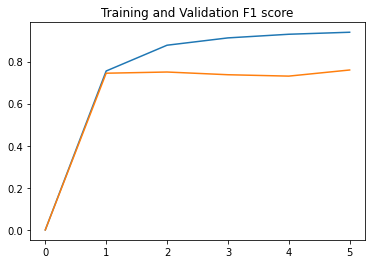

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Load the model
model.load_state_dict(torch.load('trained_cnn_model'))
model = model.to("cuda")

# Train the model on the development dataset, and evaluate it on the test dataset
# Print trainining and evaluation accuracies

total_step = len(X_dev)
loss_list = []
training_accuracy = [0]
dev_accuracy = [0]

for epoch in range(num_epochs):

  predicted_labels = []
  correct_labels = []

  for i, (sentences, category) in enumerate(training_dataloader):
    tensors = linesToTensors(sentences)
    tensors = tensors.to("cuda")
    labels = categoriesToTensors(category)
    labels = labels.to("cuda")

    outputs = model(tensors)
    outputs = outputs.to("cuda")

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the training accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc = correct / total

    predicted_labels.extend([int(label) for label in predicted])
    correct_labels.extend([int(label) for label in labels])

  #Store training accuracy
  training_accuracy.append(f1_score(predicted_labels, correct_labels, average='macro'))
  print('Training. Epoch-', epoch, 'F-score:', f1_score(predicted_labels, correct_labels, average='macro'))
  test = [(sentence, category) for sentence, category in zip(X_test,y_test)]

  #Check validation accuracy
  predicted = []
  correct = []
  total = len(test)
  for i, (sentence, category) in enumerate(test):
    tensor = torch.reshape(lineToTensor(sentence), (1, n_letters+1, 5000))
    tensor = tensor.to("cuda")
    outputs = model(tensor)
    outputs = outputs.to("cpu")
    label = Variable(torch.LongTensor([label_list.index(category)]))
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction)
    correct.append(label)
  dev_accuracy.append(f1_score(predicted, correct, average='macro'))
  print('Development. Epoch-', epoch, 'F-score:', f1_score(predicted, correct, average='macro'))

#Plot training and evaluation accuracy
n_epochs = [iter for iter in range(len(training_accuracy))]
plt.plot(n_epochs, training_accuracy)
plt.plot(n_epochs, dev_accuracy)
plt.title('Training and Validation F1 score')
plt.show()